In [5]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [6]:
# Converting image into black white
cat_bw = np.array(Image.open('cat_text.jpg').convert('1'))
hello_bw = np.array(Image.open('hello_text.jpg').convert('1'))

In [45]:
resized_cat = np.array(Image.open('cat_text.jpg').resize((100,30)).convert('1'))
resized_hello = np.array(Image.open('hello_text.jpg').resize((130,30)).convert('1'))

In [8]:
def convolution_1d(data: list, kernel: list) -> list:
    """ 1D convolution
    Input:
        - data: input data
        - kernel: input kernel
    Returns:
        - Convolved output of data and kernel
    """
    flipped_kernel = [kernel[x] for x in reversed(range(len(kernel)))]
    convolved_data = np.zeros(len(data))
    for i in range(len(data)):
        for j in range(len(flipped_kernel)):
            if j == 0 and i - 1 >= 0:
                convolved_data[i] += data[i - 1] * flipped_kernel[j]
            elif j == len(flipped_kernel) and i + 1 < len(data):
                convolved_data[i] += data[i + 1] * flipped_kernel[j]
            else:
                convolved_data[i] += data[i] * flipped_kernel[j]
    return convolved_data

In [9]:
def edge_detection(data: list, display: bool = False) -> list:
    """ Filters the input, so edges are visible
    Input:
        - data: input image
        - display: show the result filtered image
    Return: 
        - Filtered image array
    """
    h = np.array([1, 0, -1])
    rows, cols = data.shape
    y_rows = np.zeros(data.shape)
    for i in range(rows):
        # y_rows[i,:] = signal.convolve(data[i,:], h, 'same')
        y_rows[i,:] = convolution_1d(data=data[i,:], kernel=h)

    y_cols = np.zeros(data.shape)
    for i in range(cols):
        # y_cols[:, i] = signal.convolve(data[:, i], h, 'same')
        y_cols[:, i] = convolution_1d(data=data[:, i], kernel=h)

    y_IF = np.sqrt(y_rows**2 + y_cols**2)
    if (display):
        plt.figure(figsize=(10,6))
        plt.imshow(y_IF, 'gray')
        plt.title('Gradient')
        plt.show()
    return y_IF

In [10]:
def char_col_finder(data: list) -> list[tuple]:
    """ Find column indices of character(s)
    Input:
        - data: input image
    Return:
        - List of column pair indices that contains a character
    """
    col = []
    found = False
    pair = []
    for c in range(data.shape[1]):
        if c + 1 <= data.shape[1]:
            found = False
            # Find White 1.0 <
            for p in data[:, c:c+1]:
                if p >= 1.0:
                    found = True
                    break
            if len(pair) == 0 and found and c != 0:
                pair.append(c)
            elif len(pair) == 1 and not found:
                pair.append(c)
                col.append(pair)
                pair = []
    return col

In [11]:
def char_row_finder(data: list) -> []:
    """ Find the min and max row indices that exists a white pixel
    Input:
        - data: input image
    Return:
        - top and bottom indices
    """
    top = data.shape[0]
    bottom = 0

    for r in range(data.shape[0]):
        if r + 1 <= data.shape[0]:
            for p in data[r:r+1, 5:data.shape[1]-5][0]:
                if p >= 1.0:
                    if r < top:
                        top = r if r != 0 else top
                    if r > bottom:
                        bottom = r if r != data.shape[0]-1 else bottom
                    break
    return [top, bottom]

        

In [12]:
def show_cropped_char(crop_array: list):
    """ Display the cropped characters
    Input:
        - crop_array: list of cropped image
    """
    for i in range(len(crop_array)):
        plt.subplot(1, len(crop_array), i + 1)
        plt.imshow(crop_array[i])
    plt.show()

In [43]:
def pad_cropped(data: list) -> []:
    """ Pad zeros to cropped data
    Input:
        - data: cropped image
    Return:
        - Cropped data with zeros padded, so shape is (28, 28)
    """
    if data.shape < (28, 28):
        print(data.shape)
        top = (28 - data.shape[0]) // 2
        bottom = 28 - top - data.shape[0]
        left = (28 - data.shape[1]) // 2
        right = 28 - left - data.shape[1]
        new_array = np.pad(data, ((top, bottom),(left, right)), 'constant')
        return new_array
    else:
        print("Unable to pad, cropped image too large for model")
        return []

In [40]:
def text_segmentation(data: list, display: bool = False) -> []:
    """ Segments an image with characters into individual characters
    Input:
        - data: input image
    Return:
        - List of cropped characters from input
    """
    edge_array = edge_detection(data=data, display=display)
    # crop top and bottom, since those will be edges too
    top, bottom = char_row_finder(edge_array)
    cropped_array = edge_array[top:bottom, :]

    # find the column indices pairs of each found character
    cutoff_col_idx = char_col_finder(cropped_array)

    characters = []
    display_char = []
    
    for (c0, c1) in cutoff_col_idx:
        new_array = pad_cropped(cropped_array[:, c0:c1])
        if len(new_array) > 0:
            display_char.append(new_array)
            characters.append(new_array.flatten())

    if display:
        show_cropped_char(display_char)

    return characters

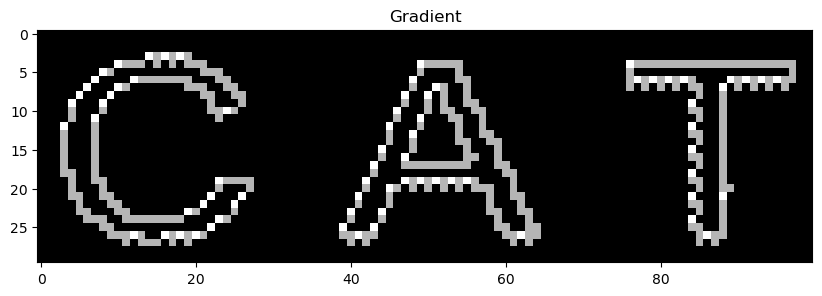

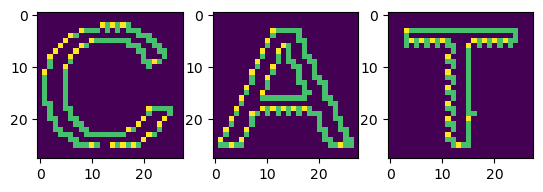

In [41]:
cat_cropped_data = text_segmentation(data=resized_cat, display=True)

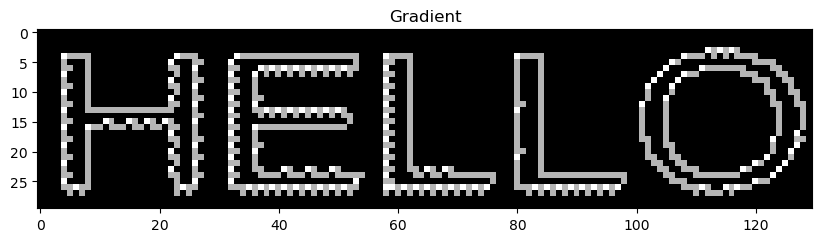

(24, 24)
(24, 23)
(24, 19)
(24, 19)
(24, 28)


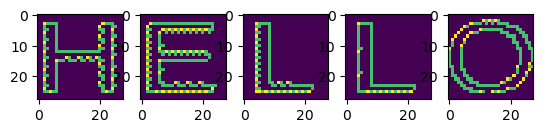

In [46]:
hello_cropped_data = text_segmentation(data=resized_hello, display=True)

In [36]:
def prediction_string(prediction: list) -> str:
    """ Convert predicted value into the string mapping
    Input:
        - prediction: array of the predicted value in EMNIST mapping (1 = A, 2 = B, ...)
    Return:
        - EMNIST mapping to string
    """
    pred_str = ""
    for p in prediction:
        pred_str += chr(64 + p)

    return pred_str
